# Import all the required libraries

In [1]:
# TensorFlow & Keras for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Data Handling
import numpy as np
import os
import zipfile
import glob
import cv2
import matplotlib.pyplot as plt

# Sklearn for train-test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import random

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load the dataset Path

In [3]:
DATASET_PATH = './augmented_data'

In [4]:
os.listdir(DATASET_PATH)

['no', 'yes']

In [5]:
IMG_SIZE = (224, 224)

# load images

In [6]:
# Function to load images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)  # Resize
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(label)
    return images, labels

# Load tumor (yes) images

In [7]:
tumor_images, tumor_labels = load_images_from_folder(os.path.join(DATASET_PATH, "yes"), label=1)

# Load no-tumor (no) images

In [8]:

no_tumor_images, no_tumor_labels = load_images_from_folder(os.path.join(DATASET_PATH, "no"), label=0)

# Convert lists to NumPy arrays

In [9]:

X = np.array(tumor_images + no_tumor_images)
y = np.array(tumor_labels + no_tumor_labels)

# Split into training & validation sets

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
len(tumor_images)

1085

In [12]:
y_train.shape

(1730,)

# Load pre-trained VGG16 model (without top layers)

In [13]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [14]:
# Freeze convolutional layers (to keep pre-trained features)
for layer in base_model.layers:
    layer.trainable = False

In [15]:
BATCH_SIZE = 32

# Create ImageDataGenerator for preprocessing
# datagen = ImageDataGenerator(
#     rescale=1./255,  # Normalize pixel values
#     validation_split=0.3  
# )


# Define ImageDataGenerator with Augmentations
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=20,       # Rotate images by 20 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,         # Apply shearing
    zoom_range=0.2,          # Randomly zoom in on images
    horizontal_flip=True,    # Flip images horizontally
    fill_mode="nearest",     # Fill missing pixels
    validation_split=0.2     # Keep 20% for validation
)

# Load training data

In [16]:

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)


Found 1731 images belonging to 2 classes.


# Load validation data

In [17]:

val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

Found 432 images belonging to 2 classes.


In [43]:
val_generator.class_indices

{'no': 0, 'yes': 1}

In [47]:
val_generator.classes[ val_generator.classes == 0 ]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [19]:
# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)  # Binary classification (yes/no)

# Create model

In [20]:

model = Model(inputs=base_model.input, outputs=x)


In [21]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [22]:
print("Training samples found:", train_generator.samples)
print("Validation samples found:", val_generator.samples)

Training samples found: 1731
Validation samples found: 432


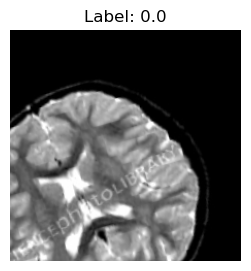

In [23]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Display first image
plt.figure(figsize=(5,3))
plt.imshow(images[2])
plt.title(f"Label: {labels[2]}")
plt.axis('off')
plt.show()


# Display the random 30 samples

In [24]:

tumor_path = os.path.join(DATASET_PATH, "yes")  # Tumor images
no_tumor_path = os.path.join(DATASET_PATH, "no")  # No-Tumor images

# Get all image filenames
tumor_images = os.listdir(tumor_path)
no_tumor_images = os.listdir(no_tumor_path)

# Randomly select 30 images from each category
tumor_sample = random.sample(tumor_images, 30)
no_tumor_sample = random.sample(no_tumor_images, 30)


In [25]:
def display_images(image_list, category, folder_path):
    plt.figure(figsize=(15, 10))  # Set figure size
    for i, img_name in enumerate(image_list):
        img_path = os.path.join(folder_path, img_name)  # Get full image path
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(5, 6, i + 1)  # Arrange images in a 5x6 grid
        plt.imshow(img)
        plt.axis("off")  # Hide axes
    plt.suptitle(category, fontsize=16)  # Set title
    plt.show()


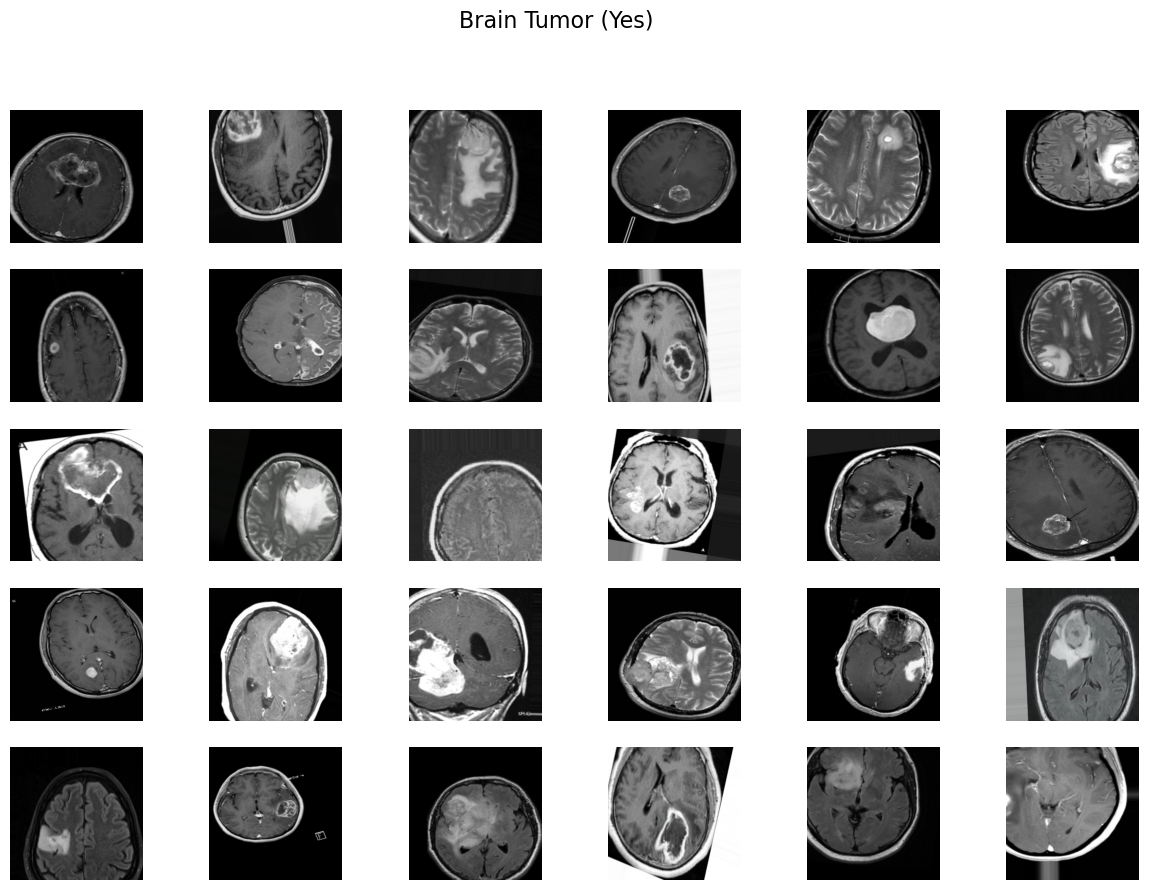

In [26]:
# Display 30 Tumor images
display_images(tumor_sample, "Brain Tumor (Yes)", tumor_path)

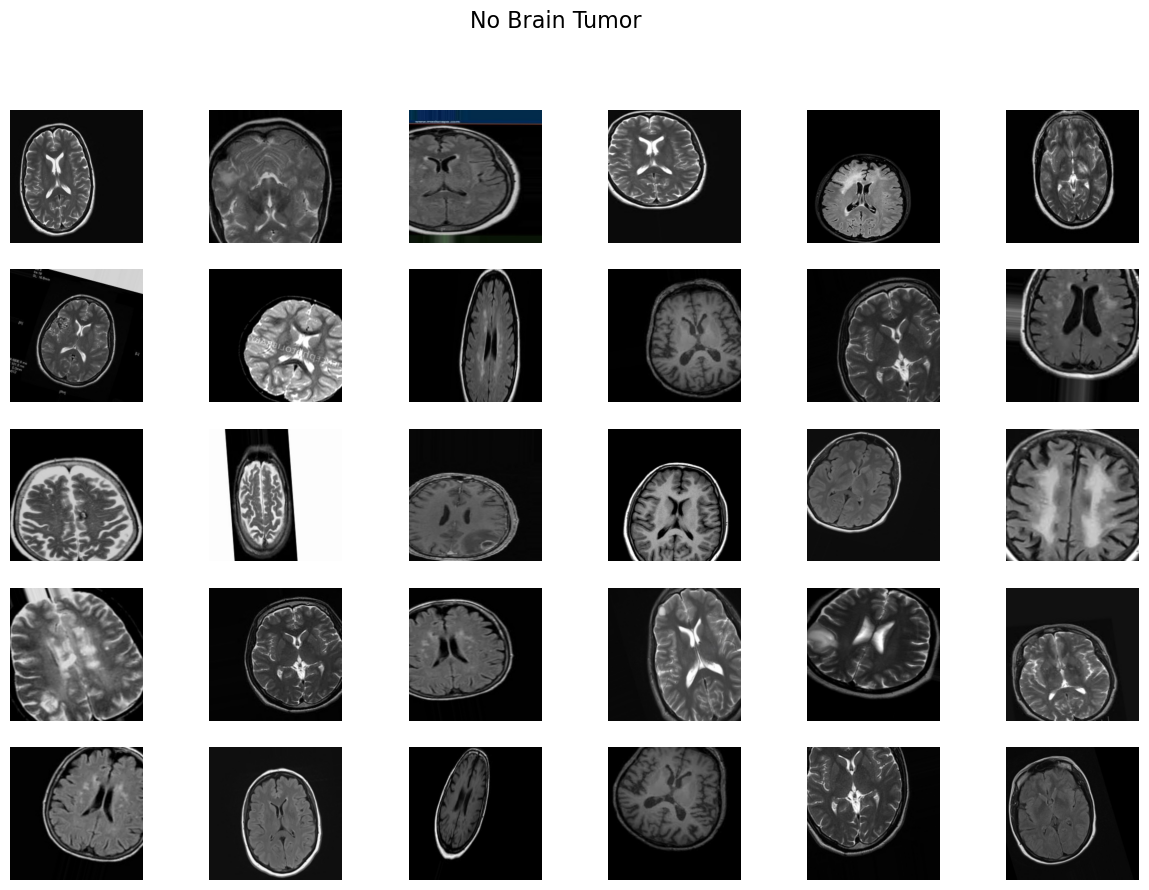

In [27]:
# Display 30 No-Tumor images
display_images(no_tumor_sample, "No Brain Tumor", no_tumor_path)

# Train model

In [28]:
history = model.fit(
    train_generator,  
    validation_data=val_generator,
    epochs=10,  
    verbose=1
)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 464s 8s/step - accuracy: 0.6005 - loss: 0.7158 - val_accuracy: 0.6157 - val_loss: 0.6856
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 446s 8s/step - accuracy: 0.7221 - loss: 0.5530 - val_accuracy: 0.6204 - val_loss: 0.6619
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 452s 8s/step - accuracy: 0.7605 - loss: 0.4876 - val_accuracy: 0.6991 - val_loss: 0.5953
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 446s 8s/step - accuracy: 0.7860 - loss: 0.4670 - val_accuracy: 0.6620 - val_loss: 0.5916
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 451s 8s/step - accuracy: 0.7813 - loss: 0.4479 - val_accuracy: 0.7060 - val_loss: 0.5672
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 451s 8s/step - accuracy: 0.7925 - loss: 0.4247 - val_accuracy: 0.7222 - val_loss: 0.5692
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 466s 8s/step - accuracy: 0.7884 - loss: 0.4371 - val_accuracy: 0.6852 - val_loss: 0.6299
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 460s 8s/step - accuracy: 0.8186 - loss: 0.4031 - val_accuracy: 0.7199 - v

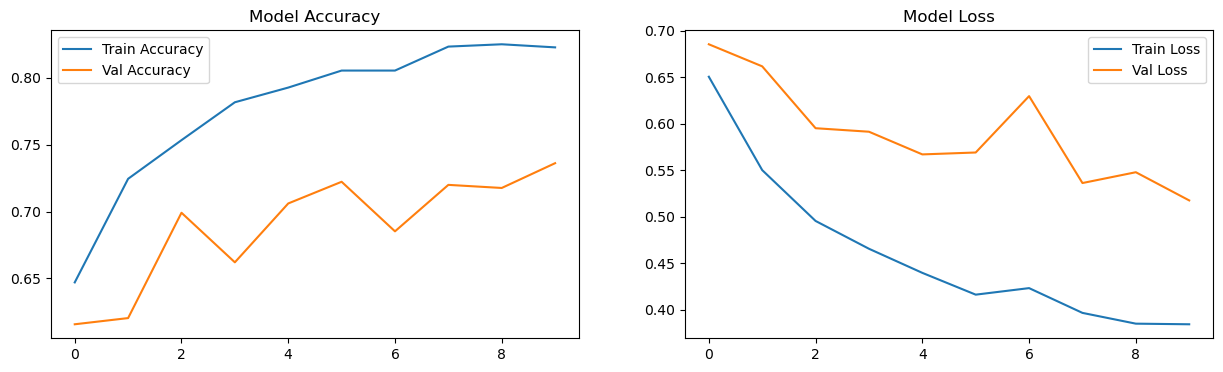

In [29]:

plt.figure( figsize=(15,4) )

plt.subplot(1,2,1)

# Plot training & validation accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot training & validation loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Model Loss")
plt.show()


# Confusion Matrix

In [30]:
# Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_generator:
    y_true.extend(labels)  # Actual labels
    y_pred.extend(model.predict(images).flatten())  # Predicted probabilities
    if len(y_true) >= val_generator.samples:  # Stop when we have all validation samples
        break

# Convert probabilities to binary (0 or 1)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


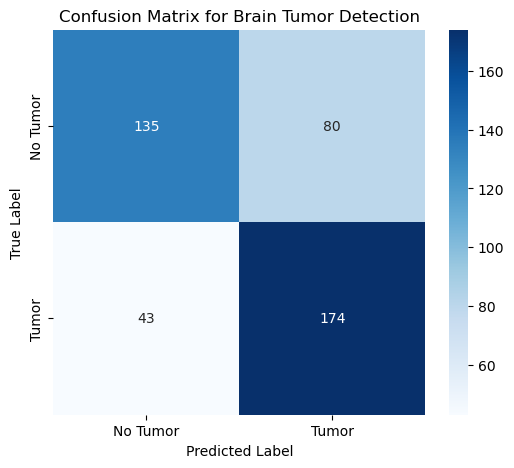

In [31]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Brain Tumor Detection")
plt.show()
